# <center> <font style="color:rgb(100,109,254)"> Playing Rock, Paper, Scissors with AI</font> </center>


##  <font style="color:rgb(134,19,348)">Import Libraries </font>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, MaxPool2D, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import choice,shuffle
from scipy import stats as st

from collections import deque

In [2]:
# Declare arrays to store hand sign data
rock_data, paper_data, scissor_data, nothing_data = [], [], [], []
num_samples = 100

# Initialize the camera
cap = cv2.VideoCapture(0)

# Frame from camera video
frame = None

# Trigger tells us when to start recording
trigger = False

# hand_sign to hold name of each of hand sign.
hand_sign = ''

# Counter keeps count of the number of samples collected
counter = 0

# Indicator text on screen
text = ''

# This the ROI size, the size of images saved will be box_size - 10 (= 224)
box_size = 234

# Getting the width of the frame from the camera properties
width = int(cap.get(3))

In [3]:
def create_ui_pro(title):
    global frame
    
    # Flip the frame to make it more realistic.
    frame = cv2.flip(frame, 1)

    # Define ROI for capturing samples
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)

    # Make a resizable window.
    cv2.namedWindow(title, cv2.WINDOW_NORMAL)

In [4]:
def show_ui(title):
    global frame, text
    
    # Show the text on the image
    cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)

    # Display the window
    cv2.imshow(title, frame)

##  <font style="color:rgb(134,19,348)"> Step 1: Gather Data, for rock, paper scissor classes.</font>

In [14]:
def add_hand_sign_data():
    
    global frame, counter, text, trigger, hand_sign, rock_data, paper_data, scissor_data, nothing_data    
    
    # If counter is equal to the number samples then reset triger and the counter
    if counter == num_samples:
        trigger = not trigger
        counter = 0
    # If trigger is True than start capturing the samples
    if trigger:

        # Grab only slected roi
        roi = frame[5: box_size-5 , width-box_size + 5: width -5]

        # Append the roi and class name to the list with the selected class_name
        # eval(hand_sign_data).append(roi)
        if hand_sign == 'rock':
            rock_data.append(roi)
        elif hand_sign == 'paper':
            paper_data.append(roi)
        elif hand_sign == 'scissor':
            scissor_data.append(roi)
        elif hand_sign == 'nothing':
            nothing_data.append(roi)


        # Increment the counter 
        counter += 1 

        # Text for the counter
        text = "Collected Samples of {}: {}".format(hand_sign, counter)

    else:
        text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor, 'n' for nothing."

In [15]:
def handle_user_press_button(k):
    global trigger, hand_sign
    # If user press 'r' then hand_signal_data is set to rock_data and trigger set to True  
    if k == ord('r'):
        # Trigger the variable inorder to capture the samples
        trigger = not trigger
        hand_sign = 'rock'


    # If user press 'p' then hand_signal_data is set to paper_data and trigger set to True  
    if k == ord('p'):
        trigger = not trigger
        hand_sign = 'paper'

    # If user press 's' then hand_signal_data is set to scissor_data and trigger set to True  
    if k == ord('s'):
        trigger = not trigger
        hand_sign = 'scissor'

    # If user press 's' then hand_signal_data is set to nothing_data and trigger set to True
    if k == ord('n'):
        trigger = not trigger
        hand_sign = 'nothing'

In [16]:
# Loop through frames
while True:
    global frame
    
    # Read frame by frame
    ret, frame = cap.read()
    
    # Break the loop if there is trouble  reading the frame.
    if not ret:
        break
        
    # create UI properties
    create_ui_pro('Collect Data')

    # Add hand sign data to arrays
    add_hand_sign_data()

    # show UI
    show_ui('Collect Data')
    
    # Wait 1 ms
    k = cv2.waitKey(1)

    # Handle user press button
    handle_user_press_button(k)

    # Exit if user presses 'q'
    if k == ord('q'):
        break

#  Release the camera and destroy the window
cap.release()
cv2.destroyAllWindows()

####  <font style="color:rgb(134,19,348)"> (Optional) Visualize the Data:
 </font>

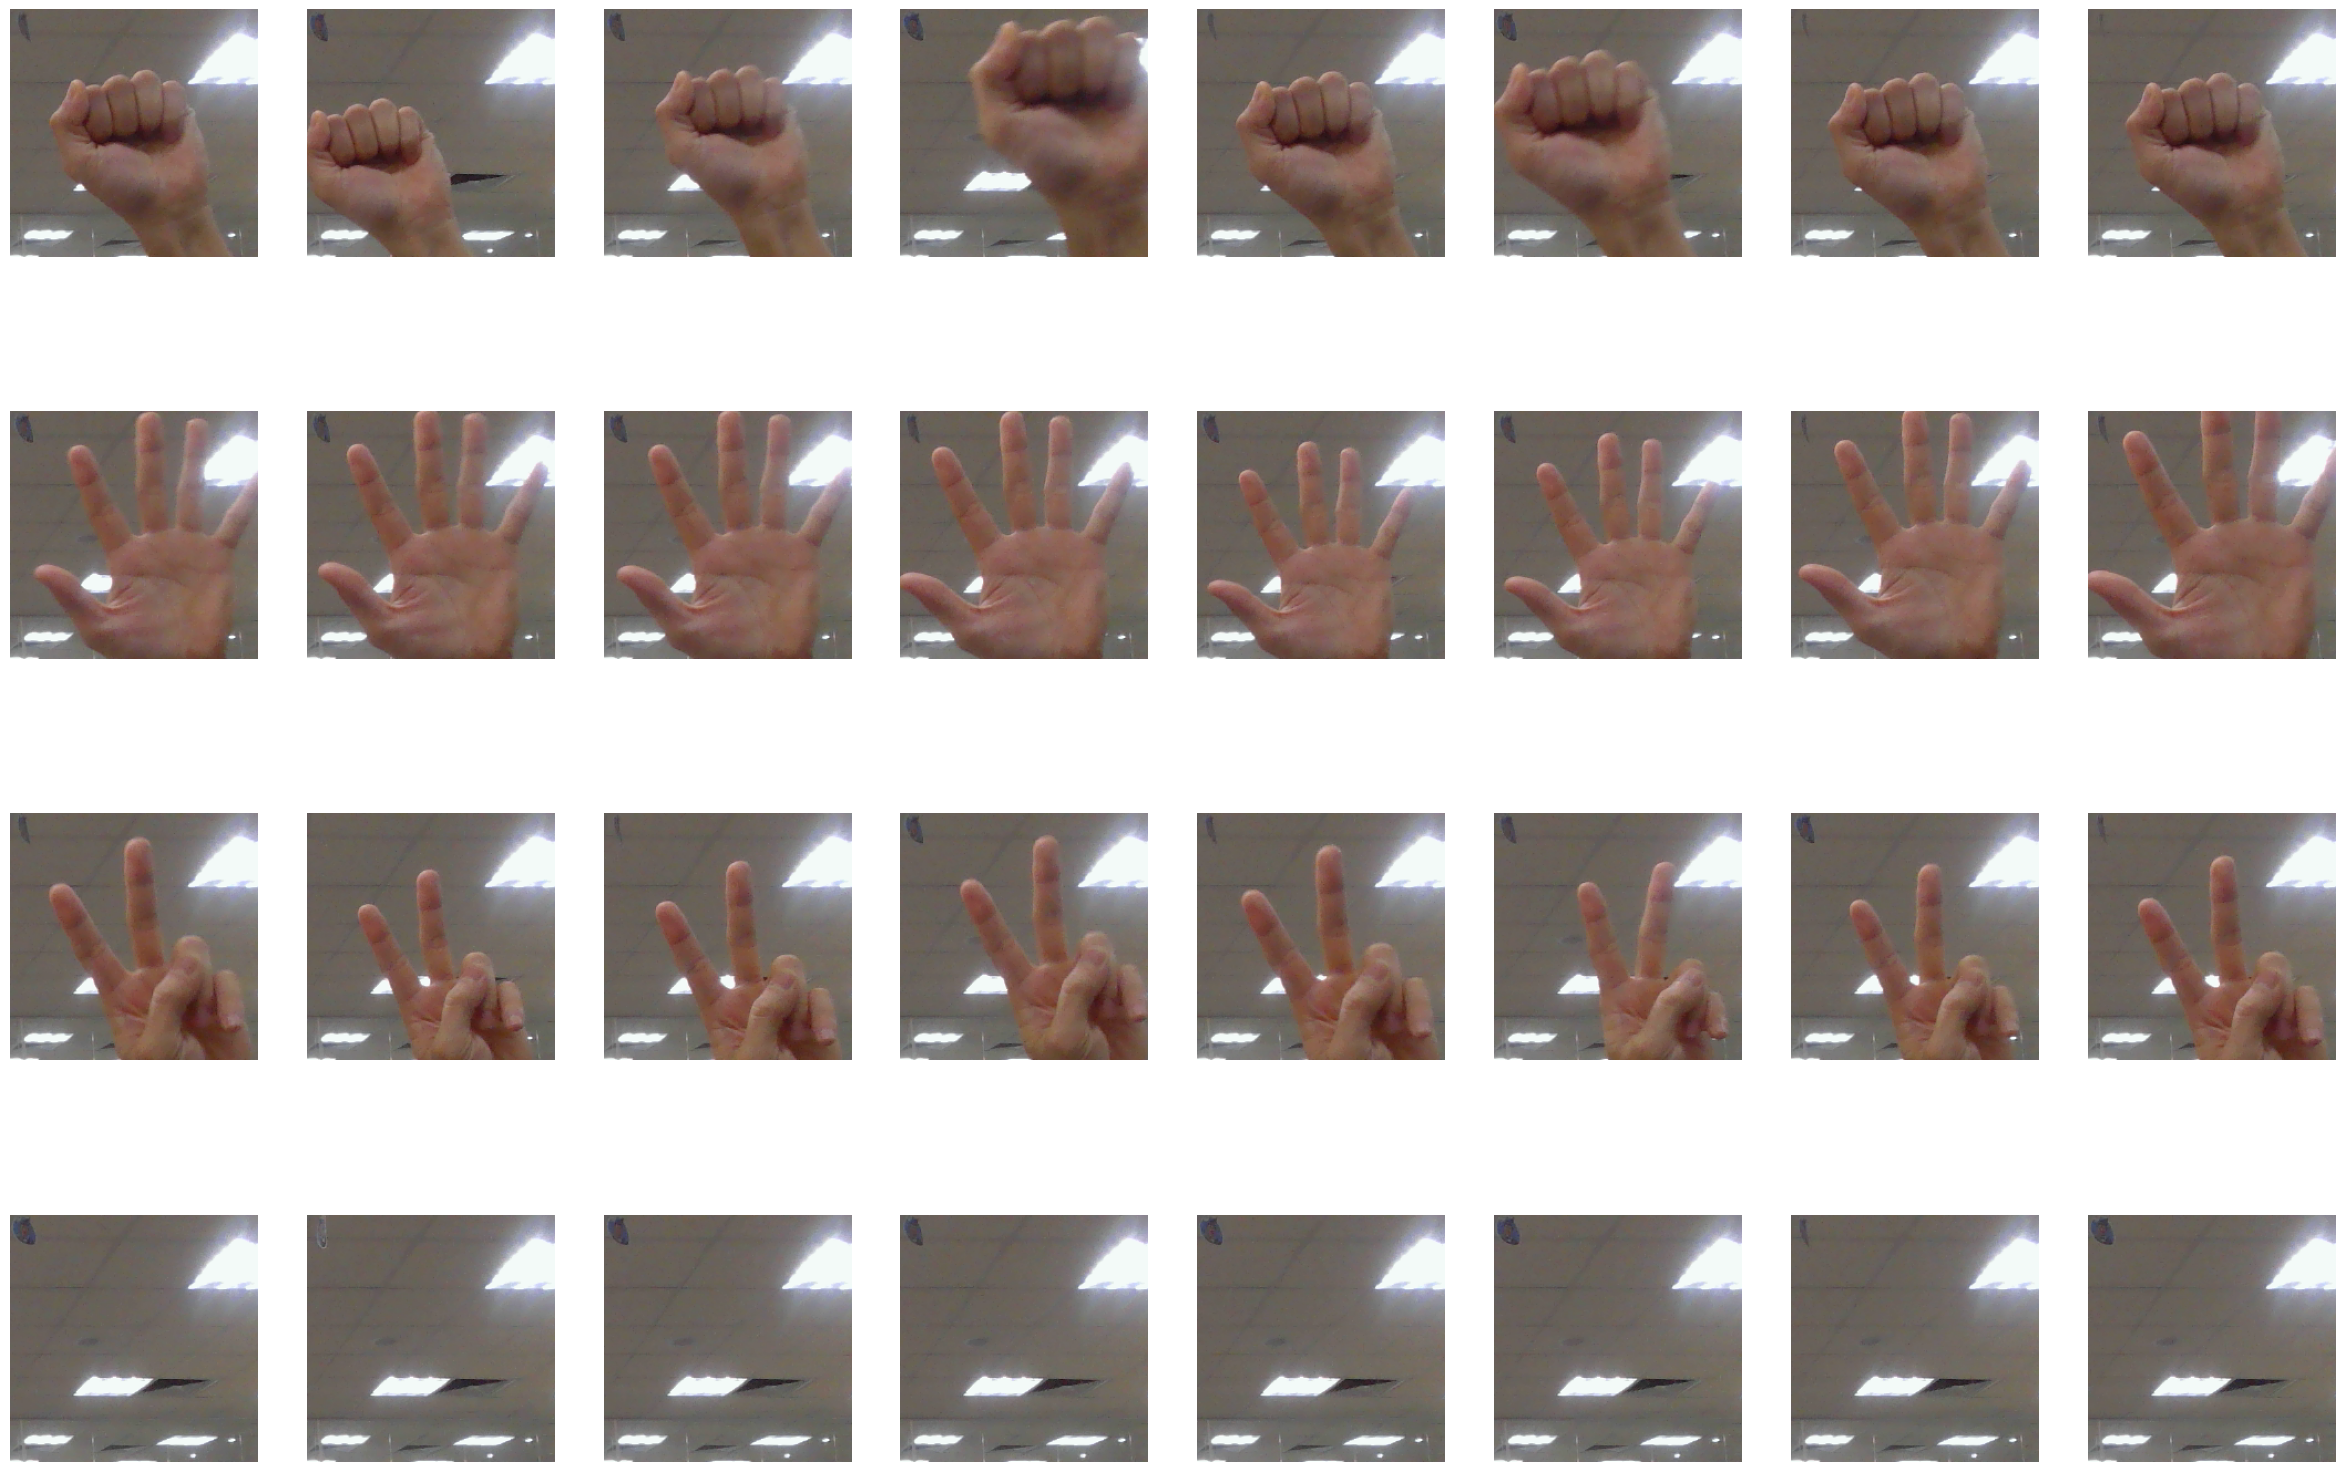

In [17]:
# Set the figure size
plt.figure(figsize=[30,20])
# Set the rows and columns
rows, cols = 4, 8
# Iterate for each class
for class_index, each_list in enumerate([rock_data, paper_data, scissor_data, nothing_data]):
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(num_samples, size=8);  
    # Plot the examples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i)
        plt.imshow(each_list[example_index][:,:,::-1])
        plt.axis('off')
plt.show()

##  <font style="color:rgb(134,19,348)"> Step 2: Preprocess Data and Split it </font>

In [18]:
# Combine the labels of all classes together
labels = ['rock' for _ in rock_data] + ['paper' for _ in paper_data] + 
    ['scissor' for _ in scissor_data] +['nothing' for _ in nothing_data]

# Combine the images of all classes together
images = [img_dt for img_dt in rock_data] + [img_dt for img_dt in paper_data] + 
    [img_dt for img_dt in scissor_data] +[img_dt for img_dt in nothing_data]

# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0

# Create an encoder Object
encoder = LabelEncoder()

# Encode labels. i.e. nothing = 0, paper = 1, rock = 2, scissor = 3 (mapping is done in alphabatical order)
labels = encoder.fit_transform(labels)

# Convert the integer labels into one hot format. i.e. 0 = [1,0,0,0]  etc.
one_hot_labels = to_categorical(labels, 4)

# Now we're splitting the data, 75% for training and 25% for testing.
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)

# Empty memory from RAM
images = []

# This can further free up memory from RAM but be careful, if you won't be able to chage split % after this.
# rock, paper, scissor = [], [], []

##  <font style="color:rgb(134,19,348)">Step 3: Train AI model </font>

In [19]:
# This is the input size which our model accepts.
image_size = 224

# Loading pre-trained trainY MobileNetV2 without the head by doing include_top = False
base_model = tf.keras.applications.MobileNetV2( input_shape=(image_size, image_size, 3), 
                                               include_top=False, weights='imagenet')

# Freeze the whole model 
base_model.trainable = False

In [20]:
# Adding our own custom head
# Start by taking the output feature maps from MobileNetV2
x = base_model.output

# Convert to a single dimensional vector by Global Average Pooling. 
# We could also use Flatten()(x) GAP is more effective reduces params and controls overfitting.
x = GlobalAveragePooling2D()(x)

# Adding a dense layer with 512 units
x = Dense(500, activation='relu')(x) 

# Dropout 20% of the activations, helps reduces overfitting
x = Dropout(0.50)(x)

# The fianl layer will contain 4 output units (no of units = no of classes) with softmax function.
preds = Dense(4,activation='softmax')(x) 

# Construct the full model
model = Model(inputs=base_model.input, outputs=preds)

# Check the number of layers in the final Model
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 158


In [21]:
# Adding transformations that I know would help, you can feel free to add more.
# I'm doing horizontal_flip = False, incase you aren't sure which hand you would be using you can make 
# that True.

augment = ImageDataGenerator( 
        rotation_range=20,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,    
        fill_mode="nearest"
)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [23]:
# Set batchsize according to your system
epochs = 15
batchsize = 20

# Start training
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
    steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

# Use model.fit_generator function instead if TF version < 2.2
#history = model.fit_generator(x = augment.flow(trainX, trainY, batch_size=batchsize), 
    validation_data=(testX, testY), 
#steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 7s 372ms/step - loss: 1.1676 - accuracy: 0.5300 - val_loss: 0.1982 - val_accuracy: 1.0000
Epoch 2/15
15/15 [==============================] - 4s 294ms/step - loss: 0.3236 - accuracy: 0.9067 - val_loss: 0.0625 - val_accuracy: 1.0000
Epoch 3/15
15/15 [==============================] - 5s 300ms/step - loss: 0.1730 - accuracy: 0.9567 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 4/15
15/15 [==============================] - 4s 292ms/step - loss: 0.1270 - accuracy: 0.9667 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 5/15
15/15 [==============================] - 5s 296ms/step - loss: 0.0928 - accuracy: 0.9867 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 6/15
15/15 [==============================] - 4s 293ms/step - loss: 0.0533 - accuracy: 0.9900 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 7/15
15/15 [==============================] - 4s 297ms/step - loss: 0.0489 - accuracy: 0.9967 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 

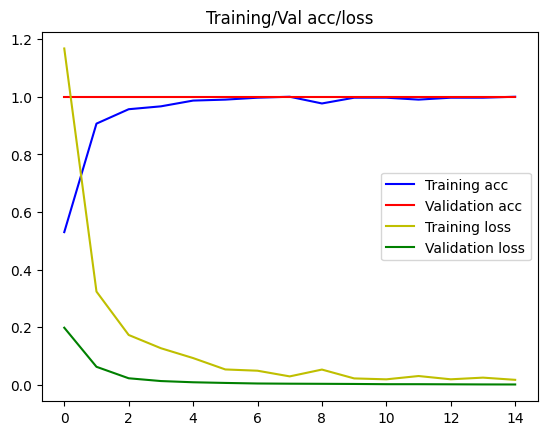

In [24]:
# Plot the accuracy and loss curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training/Val acc/loss')
plt.legend()

plt.show()

####  <font style="color:rgb(134,19,348)"> Save the model </font>

In [25]:
model.save("rps4.h5", overwrite=True)

/home/sunt/anaconda3/envs/game/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


##  <font style="color:rgb(134,19,348)"> Step 4: Test on Live Webcam Feed</font>

###  <font style="color:rgb(134,19,348)"> Load the model </font>

In [5]:
model = load_model("rps4.h5")

### Function to make prediction from AI model

In [6]:
# List will be used to map probabilities to class names, Label names are in alphabatical order.
hand_signs_list = ['nothing', 'paper', 'rock', 'scissor']

In [7]:
def make_prediction():
    global frame
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    # Normalize the image like we did in the preprocessing step, also convert float64 array.
    roi = np.array([roi]).astype('float64') / 255.0
 
    # Get model's prediction.
    pred = model.predict(roi)
    
    # Get the index of the target class.
    target_index = np.argmax(pred[0])

    # Get the probability of the target class
    prob = np.max(pred[0])
    
    return pred, prob

### Main flow to test AI model

In [8]:
while True:
    # capture frames
    ret, frame = cap.read()
    if not ret:
        break
        
    # create UI properties
    create_ui_pro('Rock Paper Scissors')
    # show UI
    pred, prob = make_prediction()

    # Show results
    text =  'prediction: {} {:.2f}%'.format(hand_signs_list[np.argmax(pred[0])], prob*100)
    show_ui('Rock Paper Scissors')

    # press q to quit
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()